# Explanation of Preprocessing Using Mel Spectrograms

"""
### Dataset Preprocessing Overview

This notebook preprocesses the ASVspoof 2019 Logical Access dataset by extracting **Mel spectrograms** from audio files. 
The Mel spectrograms provide a time-frequency representation of the audio signal and are widely used in speech and audio processing tasks. Below is an overview of the preprocessing steps and their significance:

---

### Steps in Preprocessing

1. **Data Loading**:
   - The dataset is organized using protocol files that link each audio file to its label (`bonafide` or `spoof`).
   - Labels are loaded into a dictionary for efficient lookup during processing.

2. **Mel Spectrogram Extraction**:
   - Audio files are processed using **Librosa** to extract Mel spectrograms:
     - **Mel Scale**: Mimics the human ear's perception of frequency, emphasizing frequencies that humans are more sensitive to.
     - **Power to Decibel Conversion**: Converts power spectrograms into decibel scale for better interpretability.
   - The spectrograms are padded or truncated to a fixed number of time steps (`MAX_TIME_STEPS`) to ensure uniform input size.

3. **Shuffling and Dataset Splitting**:
   - Data points (spectrograms, labels, and file paths) are shuffled to prevent unintended biases in the training and testing sets.
   - Subsets of the dataset are created with 10%, 50%, and 100% of the data for flexible experimentation.

4. **Saving Preprocessed Data**:
   - Preprocessed features, labels, and file paths are stored in `.pkl` files for future use. This avoids the need to repeatedly extract features from the raw audio, saving significant time.

---

### Advantages of Mel Spectrograms

- **Rich Representation**: Mel spectrograms capture both temporal and spectral information, making them suitable for models like CNNs and RNNs that excel at handling 2D inputs.
- **Standardized Format**: Uniform dimensions ensure compatibility with batch processing in deep learning frameworks.
- **Human-Like Frequency Emphasis**: The Mel scale provides a more intuitive representation for tasks like speech recognition and audio classification.

---

### When to Use Mel Spectrograms?
- **Deep Learning Models**: Suitable for convolutional neural networks (CNNs) and recurrent neural networks (RNNs) that can exploit 2D spatial patterns.
- **Audio Classification**: Ideal for distinguishing patterns between "bonafide" and "spoof" audio signals.
- **Exploratory Analysis**: Visualization of spectrograms can reveal unique patterns or artifacts in audio data.

This preprocessing pipeline is designed for flexibility and compatibility with state-of-the-art machine learning models. The saved datasets can be directly loaded and used for training, evaluation, and visualization.
"""


In [6]:
# Preprocessing script for ASVspoof 2019 Logical Access Dataset using Mel Spectrograms

import os
import librosa
import numpy as np
import pickle
from tqdm import tqdm  # For progress bar
import random  # For shuffling

# Define paths
DATASET_DIR = "/mnt/c/DF/LA/"  # Update with the actual path
OUTPUT_DIR = "preprocessed_advanced_data/"  # Directory to save intermediate files

# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Protocol files
TRAIN_PROTOCOL = os.path.join(DATASET_DIR, "ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt")
DEV_PROTOCOL = os.path.join(DATASET_DIR, "ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt")
EVAL_PROTOCOL = os.path.join(DATASET_DIR, "ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt")

# Define constants
SAMPLE_RATE = 16000  # Standard sample rate
N_MELS = 64          # Number of Mel bands
DURATION = 2.5       # Duration of each audio file in seconds
MAX_TIME_STEPS = 109 # Maximum time steps for the Mel spectrograms

# Helper function to load protocol
def load_protocol(protocol_path):
    """
    Load the protocol file and return a dictionary mapping file names to labels.
    """
    labels = {}
    with open(protocol_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            file_name = parts[1]
            label = 1 if parts[-1] == "bonafide" else 0
            labels[file_name] = label
    return labels

# Feature extraction function
def extract_mel_spectrogram(file_path, sr=SAMPLE_RATE, n_mels=N_MELS, duration=DURATION, max_time_steps=MAX_TIME_STEPS):
    """
    Extract a Mel spectrogram from the audio file.
    """
    audio, _ = librosa.load(file_path, sr=sr, duration=duration)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Ensure all spectrograms have the same width (time steps)
    if mel_spectrogram.shape[1] < max_time_steps:
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, max_time_steps - mel_spectrogram.shape[1])), mode='constant')
    else:
        mel_spectrogram = mel_spectrogram[:, :max_time_steps]

    return mel_spectrogram

# Process dataset
def process_dataset(protocol, dataset_type):
    """
    Process the dataset and save the features and labels.
    """
    features = []
    labels = []
    file_paths = []

    for file_name, label in tqdm(protocol.items(), desc=f"Processing {dataset_type} dataset"):
        file_path = os.path.join(DATASET_DIR, f"ASVspoof2019_LA_{dataset_type}/flac", file_name + ".flac")
        if os.path.exists(file_path):
            mel_spectrogram = extract_mel_spectrogram(file_path)
            features.append(mel_spectrogram)
            labels.append(label)
            file_paths.append(file_path)
        else:
            print(f"File not found: {file_path}")

    # Combine and shuffle data
    combined = list(zip(features, labels, file_paths))
    random.shuffle(combined)
    features, labels, file_paths = zip(*combined)

    # Save the features and labels for different dataset sizes
    for fraction, fraction_name in [(0.1, "10"), (0.5, "50"), (1.0, "100")]:
        subset_size = int(len(features) * fraction)
        output_file = os.path.join(OUTPUT_DIR, f"{dataset_type}_{fraction_name}percent_spectrograms_labels.pkl")
        with open(output_file, "wb") as f:
            pickle.dump({
                "features": features[:subset_size],
                "labels": labels[:subset_size],
                "file_paths": file_paths[:subset_size]
            }, f)

        print(f"Processed and saved {fraction_name}% of {dataset_type} dataset to {output_file}")

# Load protocols
train_protocol = load_protocol(TRAIN_PROTOCOL)
dev_protocol = load_protocol(DEV_PROTOCOL)
eval_protocol = load_protocol(EVAL_PROTOCOL)

# Process and save datasets
process_dataset(train_protocol, "train")
process_dataset(dev_protocol, "dev")
process_dataset(eval_protocol, "eval")


Processing train dataset: 100%|███████████████████████████████████████████████████| 25380/25380 [05:18<00:00, 79.59it/s]


Processed and saved 10% of train dataset to preprocessed_data/train_10percent_spectrograms_labels.pkl
Processed and saved 50% of train dataset to preprocessed_data/train_50percent_spectrograms_labels.pkl
Processed and saved 100% of train dataset to preprocessed_data/train_100percent_spectrograms_labels.pkl


Processing dev dataset: 100%|█████████████████████████████████████████████████████| 24844/24844 [07:42<00:00, 53.68it/s]


Processed and saved 10% of dev dataset to preprocessed_data/dev_10percent_spectrograms_labels.pkl
Processed and saved 50% of dev dataset to preprocessed_data/dev_50percent_spectrograms_labels.pkl
Processed and saved 100% of dev dataset to preprocessed_data/dev_100percent_spectrograms_labels.pkl


Processing eval dataset: 100%|████████████████████████████████████████████████████| 71237/71237 [19:09<00:00, 61.95it/s]


Processed and saved 10% of eval dataset to preprocessed_data/eval_10percent_spectrograms_labels.pkl
Processed and saved 50% of eval dataset to preprocessed_data/eval_50percent_spectrograms_labels.pkl
Processed and saved 100% of eval dataset to preprocessed_data/eval_100percent_spectrograms_labels.pkl


# Import and visualization

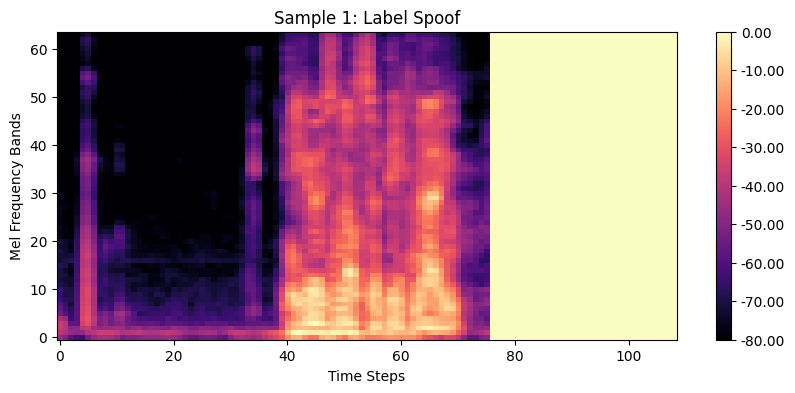

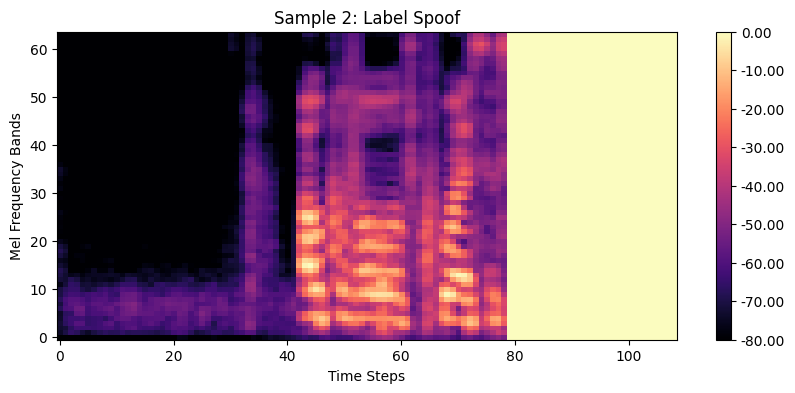

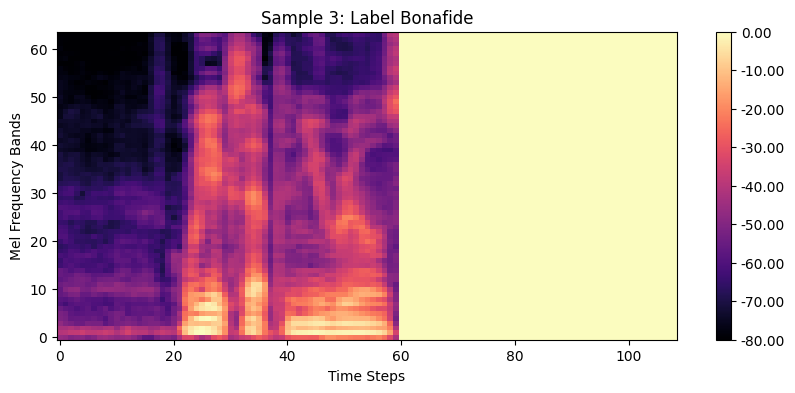

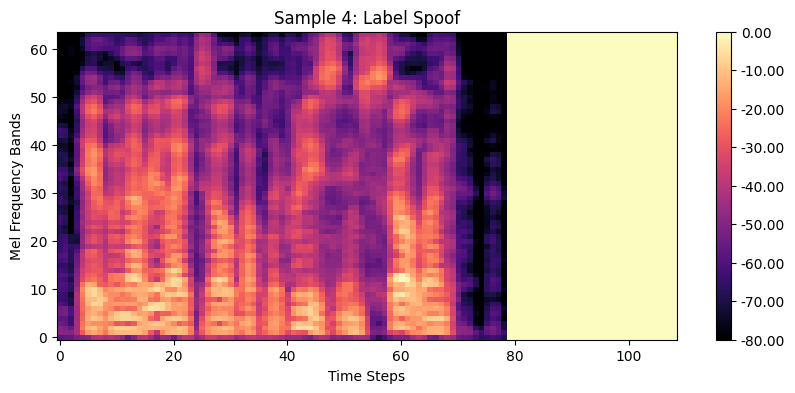

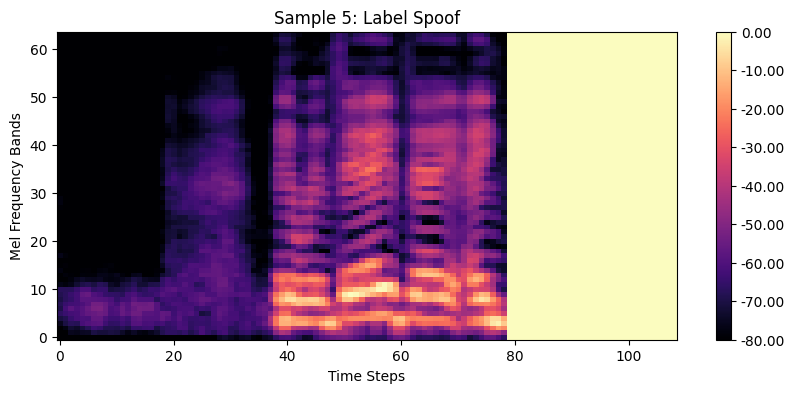

In [10]:
# Visualization of Preprocessed Mel Spectrograms

import pickle
import matplotlib.pyplot as plt
import numpy as np

# Define paths to the preprocessed data
PREPROCESSED_DIR = "preprocessed_advanced_data/"  # Update with actual path

# Function to load preprocessed data
def load_preprocessed_data(file_path):
    """
    Load the preprocessed data from a pickle file.
    """
    with open(file_path, "rb") as f:
        data = pickle.load(f)
    return data

# Visualize a subset of the data
def visualize_spectrograms(preprocessed_file, num_samples=5):
    """
    Visualize Mel spectrograms and their associated labels.

    Args:
        preprocessed_file (str): Path to the preprocessed pickle file.
        num_samples (int): Number of samples to visualize.
    """
    # Load data
    data = load_preprocessed_data(preprocessed_file)
    features = data["features"]
    labels = data["labels"]

    # Select samples to visualize
    for i in range(min(num_samples, len(features))):
        spectrogram = features[i]
        label = labels[i]

        # Plot the Mel spectrogram
        plt.figure(figsize=(10, 4))
        plt.imshow(spectrogram, aspect="auto", origin="lower", cmap="magma")
        plt.colorbar(format="%.2f")
        plt.title(f"Sample {i + 1}: Label {'Bonafide' if label == 1 else 'Spoof'}")
        plt.xlabel("Time Steps")
        plt.ylabel("Mel Frequency Bands")
        plt.show()

# Example usage
# Update with the actual file path to a preprocessed dataset file (e.g., train_10percent_spectrograms_labels.pkl)
PREPROCESSED_FILE = os.path.join(PREPROCESSED_DIR, "train_10percent_spectrograms_labels.pkl")
visualize_spectrograms(PREPROCESSED_FILE, num_samples=5)

# How to import?

In [17]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, recall_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Function to load preprocessed data
def load_preprocessed_file(file_path):
    """
    Load a preprocessed dataset file saved as a pickle (.pkl) file.

    Args:
        file_path (str): Path to the preprocessed file.

    Returns:
        dict: A dictionary containing 'features', 'labels', and 'file_paths'.
    """
    with open(file_path, "rb") as f:
        data = pickle.load(f)
    return data

# Paths to preprocessed datasets
TRAIN_FILE = "preprocessed_advanced_data/train_100percent_spectrograms_labels.pkl"  # Update this path
DEV_FILE = "preprocessed_advanced_data/dev_100percent_spectrograms_labels.pkl"  # Update this path
EVAL_FILE = "preprocessed_advanced_data/eval_100percent_spectrograms_labels.pkl"  # Update this path

# Load datasets
print("Loading preprocessed training data...")
train_data = load_preprocessed_file(TRAIN_FILE)
print(f"Training data loaded: {len(train_data['features'])} samples")

print("Loading preprocessed validation data...")
dev_data = load_preprocessed_file(DEV_FILE)
print(f"Validation data loaded: {len(dev_data['features'])} samples")

print("Loading preprocessed testing data...")
eval_data = load_preprocessed_file(EVAL_FILE)
print(f"Validation data loaded: {len(eval_data['features'])} samples")

# Extract features and labels
X_train = np.array(train_data["features"])
y_train = np.array(train_data["labels"])
paths_train = np.array(train_data["file_paths"])

print(f"Example of training feature shape: {X_train[0].shape if len(X_train) > 0 else 'N/A'}")
print(f"Example of training label: {y_train[0] if len(y_train) > 0 else 'N/A'}")

X_dev = np.array(dev_data["features"])
y_dev = np.array(dev_data["labels"])
paths_dev = np.array(dev_data["file_paths"])

print(f"Example of validation feature shape: {X_dev[0].shape if len(X_dev) > 0 else 'N/A'}")
print(f"Example of validation label: {y_dev[0] if len(y_dev) > 0 else 'N/A'}")

X_eval = np.array(eval_data["features"])
y_eval = np.array(eval_data["labels"])
paths_eval = np.array(eval_data["file_paths"])

print(f"Example of testing feature shape: {X_eval[0].shape if len(X_eval) > 0 else 'N/A'}")
print(f"Example of testing label: {y_eval[0] if len(y_eval) > 0 else 'N/A'}")


Loading preprocessed training data...
Training data loaded: 25380 samples
Loading preprocessed validation data...
Validation data loaded: 24844 samples
Loading preprocessed testing data...
Validation data loaded: 71237 samples
Example of training feature shape: (64, 109)
Example of training label: 0
Example of validation feature shape: (64, 109)
Example of validation label: 0
Example of testing feature shape: (64, 109)
Example of testing label: 0
